In [13]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import transforms

from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
from torchvision.utils import save_image
from collections import OrderedDict

import matplotlib.pyplot as plt

##Model Building

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)



In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

##Defining

In [14]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50

disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])


In [15]:
path_to_dir="/content/drive/MyDrive/Notebooks/GAN/datasets"

In [16]:
dataset = datasets.MNIST(root=path_to_dir, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0


In [17]:
for epoch in range(num_epochs):
  loop = enumerate(loader)
  for batch_idx,(real, _) in loop:

    real = real.view(-1, 784).to(device)
    batch_size = real.shape[0]

    ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
    noise = torch.randn(batch_size, z_dim).to(device)
    fake = gen(noise)
    disc_real = disc(real).view(-1)
    lossD_real = criterion(disc_real, torch.ones_like(disc_real))
    disc_fake = disc(fake).view(-1)
    lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    lossD = (lossD_real + lossD_fake) / 2
    disc.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
    output = disc(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    gen.zero_grad()
    lossG.backward()
    opt_gen.step()

    if batch_idx == 0:
        print(
            f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
        )

        with torch.no_grad():
            fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
            data = real.reshape(-1, 1, 28, 28)
            img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
            img_grid_real = torchvision.utils.make_grid(data, normalize=True)

            writer_fake.add_image(
                "Mnist Fake Images", img_grid_fake, global_step=step
            )
            writer_real.add_image(
                "Mnist Real Images", img_grid_real, global_step=step
            )
            step += 1

Epoch [0/50] Batch 0/1875                   Loss D: 0.6280, loss G: 0.7110
Epoch [1/50] Batch 0/1875                   Loss D: 0.2344, loss G: 1.5489
Epoch [2/50] Batch 0/1875                   Loss D: 0.7376, loss G: 0.9838
Epoch [3/50] Batch 0/1875                   Loss D: 0.7467, loss G: 0.7530
Epoch [4/50] Batch 0/1875                   Loss D: 0.5424, loss G: 1.1127
Epoch [5/50] Batch 0/1875                   Loss D: 0.7042, loss G: 0.9211
Epoch [6/50] Batch 0/1875                   Loss D: 0.9689, loss G: 0.8147
Epoch [7/50] Batch 0/1875                   Loss D: 0.6080, loss G: 1.4168
Epoch [8/50] Batch 0/1875                   Loss D: 0.4722, loss G: 1.2382
Epoch [9/50] Batch 0/1875                   Loss D: 0.5109, loss G: 1.4920
Epoch [10/50] Batch 0/1875                   Loss D: 0.6009, loss G: 1.2967
Epoch [11/50] Batch 0/1875                   Loss D: 0.5568, loss G: 1.1124
Epoch [12/50] Batch 0/1875                   Loss D: 0.5320, loss G: 1.1164
Epoch [13/50] Batch 0/

In [ ]:
writer_fake.close()
writer_fake.close()

In [18]:
noise = torch.randn(batch_size, z_dim).to(device)
fake = gen(noise)

In [22]:
output=fake.view(-1,28,28)

In [23]:
output.shape

torch.Size([32, 28, 28])

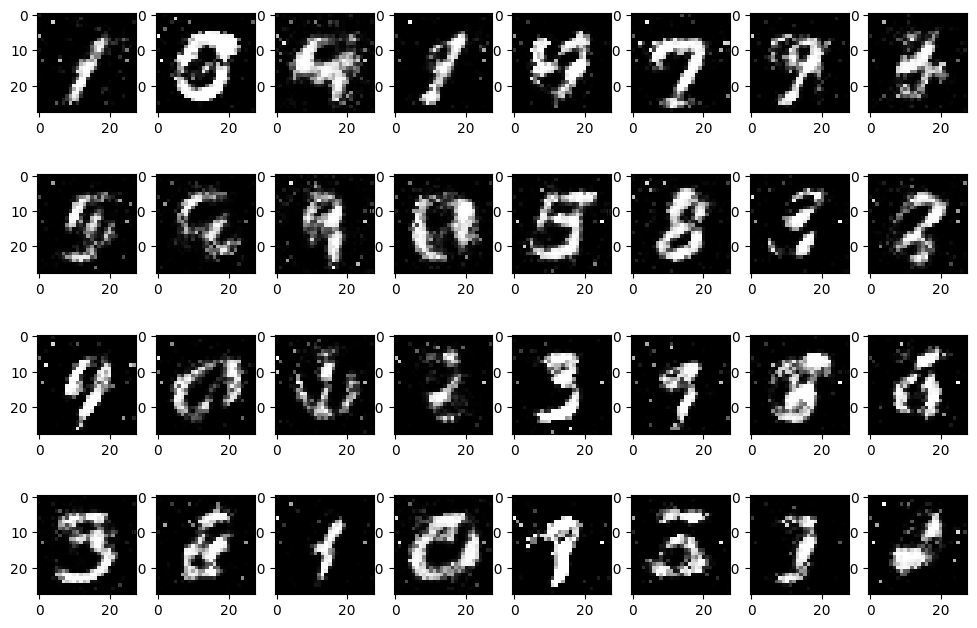

In [30]:
plt.figure(figsize=(12,8))
plt.gray()

for i in range(output.shape[0]):
  plt.subplot(4,8,i+1)
  plt.imshow(output[i].to('cpu').detach().numpy())



In [22]:
!pip install tensorrt

  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17283 sha256=f36cc8a3409702b59d00c58bcc5bb8f093253d9f4b514cd0f6302ec7af1e7403
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt


In [23]:
!tensorboard --logdir=runs --bind_all --load_fast=true

2024-03-10 23:39:51.141160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 23:39:51.141211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 23:39:51.142497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 23:39:52.290818: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
TensorBoard 2.15.2 at http://7213793909b2:6006/ (Press CTRL+C to quit)
^C
